We will now introduce some explainability technique we can use to explain our brain age prediction.

Explainability is the branch of AI that allows to explain the predictions of Deep Learning based models, which will be otherwise not possible to interpret. 

For example, we have seen that our DL pipeline obtained results superior to simple regression. We can infer that this is highly probably related to some specific features we introduced in the input, but we will hardly get access to this information. Deep Learning based models usually comes at the cost of processing data in ways not understandable for a person. If with regression we could somewhat understand how a specific feature contributed to the regression result, this is not possible with Deep Learning, unless we rely on advanced approaches.

We will introduce here 2 types of explainability:
- ante-hoc, which we will demonstrate via an advanced Regression model, XGBoost
- post-hoc, which we will informally demostrate via our best DL based architecture

In [1]:
# !pip install xgboost
# !pip install captum

In [2]:
# Imports
# General purpose
import os
from collections import Counter
from typing import List, Literal
# # DL
import torch as th
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
# Data
import monai.transforms as mtr
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Visualize
import matplotlib.pyplot as plt
import tqdm
# Fit
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.base import clone
import numpy.random as nr
# Explain
from xgboost import plot_importance
from sklearn.inspection import permutation_importance
from captum.attr import (
    InputXGradient,
    IntegratedGradients,
    LRP,
    FeatureAblation,
    ShapleyValueSampling,
)

In [80]:
# We will use this as our demogprahic dataset
masterfile_path = "../data/IXI/subjects.csv"
masterfile = pd.read_csv(masterfile_path)
masterfile = masterfile[masterfile["age"] != -1.0]
thickness_df = pd.read_csv("../data/IXI/thickness.csv")
merged = thickness_df.merge(masterfile, on='subject_id', how='inner')
merged['age'] = pd.to_numeric(merged['age'], errors='coerce')
merged['mean_thickness_weighted'] = pd.to_numeric(merged['mean_thickness_weighted'], errors='coerce')
merged['mean_thickness_simple'] = pd.to_numeric(merged['mean_thickness_simple'], errors='coerce')
merged = merged.dropna(subset=['age', 'sex', 'mean_thickness_weighted', 'mean_thickness_simple'])

# Let's extract the per thickness matrix
def make_thickness_matrix(df,
                          sample_id_cols=['subject_id', 'session', 'run'],
                          metadata_cols=['age', 'sex', 'scanner', 'site', 'diagnosis', 'dataset_name', 'registered_mni'],
                          value_col='mean_thickness_weighted',
                          hemi_col='hemi',
                          region_col='region',
                          aggfunc='mean'):
    df = df.copy()
    df['sample_id'] = df[sample_id_cols].astype(str).agg('_'.join, axis=1)

    # pivoting
    index_cols = ['sample_id'] + list(sample_id_cols) + list(metadata_cols)
    pivot = df.pivot_table(
        index=index_cols,
        columns=[hemi_col, region_col],
        values=value_col,
        aggfunc=aggfunc  # if duplicates exist (e.g., multiple entries), aggregate
    )

    pivot.columns = [f"{hemi}_{region}" for hemi, region in sorted(pivot.columns)]
    wide_df = pivot.reset_index()

    return wide_df

merged['sample_id'] = merged[['subject_id', 'session', 'run']].astype(str).agg('_'.join, axis=1)
coverage = (merged
            .drop_duplicates(subset=['sample_id', 'hemi', 'region'])
            .groupby(['hemi', 'region'])['sample_id']
            .nunique()
            .sort_values(ascending=True))

merged_filtered = merged[~((merged["region"] == 'temporalpole') & (merged["hemi"] == "rh") | (merged["region"] == "unknown"))]
merged_filtered

proper_thickness_matrix_df = make_thickness_matrix(
    df=merged_filtered,
    value_col='mean_thickness_weighted'
)

test_set = proper_thickness_matrix_df[proper_thickness_matrix_df["scanner"] == "GE-1.5T"]
train_set = proper_thickness_matrix_df[proper_thickness_matrix_df["scanner"] != "GE-1.5T"]

labels_features = [c for c in train_set.columns if "lh" in c or "rh" in c]
X = train_set[labels_features].values  # start with one raw thickness measure
y = train_set['age'].values

# Validation of about ~20%
indices = np.arange(len(train_set))
tr_idx, te_idx = train_test_split(indices, test_size=0.2, random_state=0)

X_tr = X[tr_idx]
X_te = X[te_idx]
y_tr = y[tr_idx]
y_te = y[te_idx]

In [4]:
test_set["subject_id"].nunique(), train_set["subject_id"].nunique()

(66, 494)

# Ante-Hoc

Some methods are "Ante-Hoc" explainable by design. It means they provide _tangible_ tools to interpret their decisions. As an example, let's consider LinearRegression.

In [5]:
# let's write a little function that allows us to test quickly various model
def evaluate_models_with_cv(df: pd.DataFrame,
                            labels_features,
                            include_scanner=False,
                            include_sex=False,
                            model_reg=None,
                            n_splits=5,
                            random_state=0,):
    internal_df = df.copy()
    internal_df["age_bin"] = pd.cut(df["age"], bins=10, labels=False, include_lowest=True)
    internal_df["stratify_key"] = internal_df["age_bin"].astype(str) + "_" + internal_df["sex"].astype(str)

    if model_reg is None:
        model_reg = LinearRegression()

    covariates = []
    if include_scanner:
        covariates.append("scanner")
    if include_sex:
        covariates.append("sex")

    transformers = [("num", StandardScaler(), labels_features)]
    if covariates: # only if we have covariates we append
        transformers.append(
            ("cat", OneHotEncoder(drop="first", sparse_output=False), covariates)
        )

    preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")

    model = Pipeline([
        ("preproc", preprocessor),
        ("reg", model_reg)
    ])

    X: pd.DataFrame = df[labels_features + covariates]
    y = df["age"].values

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    preds = np.zeros(len(y))

    for train_idx, val_idx in kf.split(np.arange(len(X)), y=internal_df["stratify_key"].values):
        X_tr = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_tr = y[train_idx]

        m = clone(model)
        m.fit(X_tr, y_tr)
        preds[val_idx] = m.predict(X_val)

    return {
        "r2": r2_score(y, preds),
        "mae": mean_absolute_error(y, preds),
        "preds": preds,
        "fitted_whole_model": clone(model).fit(X, y)
    }

# Evaluate
res_base = evaluate_models_with_cv(train_set, labels_features, include_scanner=False)
res_scanner = evaluate_models_with_cv(train_set, labels_features, include_scanner=True)
res_sex = evaluate_models_with_cv(train_set, labels_features, include_sex=True)
res_both = evaluate_models_with_cv(train_set, labels_features, include_scanner=True, include_sex=True)

print("Thickness only R²:", res_base["r2"], "MAE:", res_base["mae"])
print("Thickness + scanner R²:", res_scanner["r2"], "MAE:", res_scanner["mae"])
print("Thickness + sex R²:", res_sex["r2"], "MAE:", res_sex["mae"])
print("Thickness + scanner + sex R²:", res_both["r2"], "MAE:", res_both["mae"])


/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Thickness only R²: 0.4415798003747483 MAE: 10.002472490583761
Thickness + scanner R²: 0.4343853842094282 MAE: 10.074729683064058
Thickness + sex R²: 0.45725472356039076 MAE: 9.822401729461607
Thickness + scanner + sex R²: 0.45153730870766373 MAE: 9.8750650010662


In [6]:
X_test_set = test_set[labels_features + ["sex"]]
y_test_set = test_set["age"].values

def mae_fn(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    return abs_errors.mean(), abs_errors.std()

y_test_pred = res_sex["fitted_whole_model"].predict(X_test_set)
mae_m, mae_std = mae_fn(y_test_set.reshape(-1,1), y_test_pred.reshape(-1,1)) # Why mae? :)
r2 = r2_score(y_test_set, y_test_pred)
print(f"MAE (Test Set): {mae_m:.3f} +/- {mae_std:.3f}, R²: {r2:.3f}")

MAE (Test Set): 14.273 +/- 9.290, R²: -0.132


One intuitive way to understand the decision of our classifier is investigating the weights 
Let's get the weights from the sex model

In [7]:
coefficients = res_sex["fitted_whole_model"]["reg"].coef_
coefficients

array([-2.0976938 ,  1.06513789,  0.13614705, -0.4225422 ,  1.24938307,
       -2.1239698 ,  3.25360649,  2.91527726,  0.11858473,  1.27080641,
        1.42748377, -1.74442726, -2.14577825,  0.05766091,  3.16709098,
        0.57196616, -1.2432182 , -0.01288543, -4.30379396,  1.67124551,
        0.50009887, -0.21453328, -2.77104325,  0.67758204,  1.09860582,
        1.67309673, -4.62123649, -0.19819684, -1.33109859,  0.53251043,
        0.02525821, -0.7572721 ,  0.99161265, -0.82895668,  0.65575015,
       -1.68927998, -1.15998876,  2.1037062 ,  0.30513379, -1.99706259,
        1.13862325, -1.09074313,  2.11191781, -0.80796867, -0.20227567,
       -2.32719993,  0.83884676, -2.62983277, -0.26295951, -0.21839982,
        1.51909855,  0.80782647,  2.05851236, -2.12668648,  1.37997996,
        1.12574766, -1.31620913, -1.87162429,  1.82892511, -2.39600465,
        0.33699553, -0.72608713, -4.24119994])

The coefficients are the weight $\beta_d$ applied to the feature $x_{i,d}$ of our data to obtain the prediction $\hat{y_i}$
Intuitively, these represent the "weights" that have determined the final age of our candidate. Let's link them to our cortical thickness values

In [8]:
all_fts = labels_features + ["sex"]
assert len(all_fts) == coefficients.shape[0]

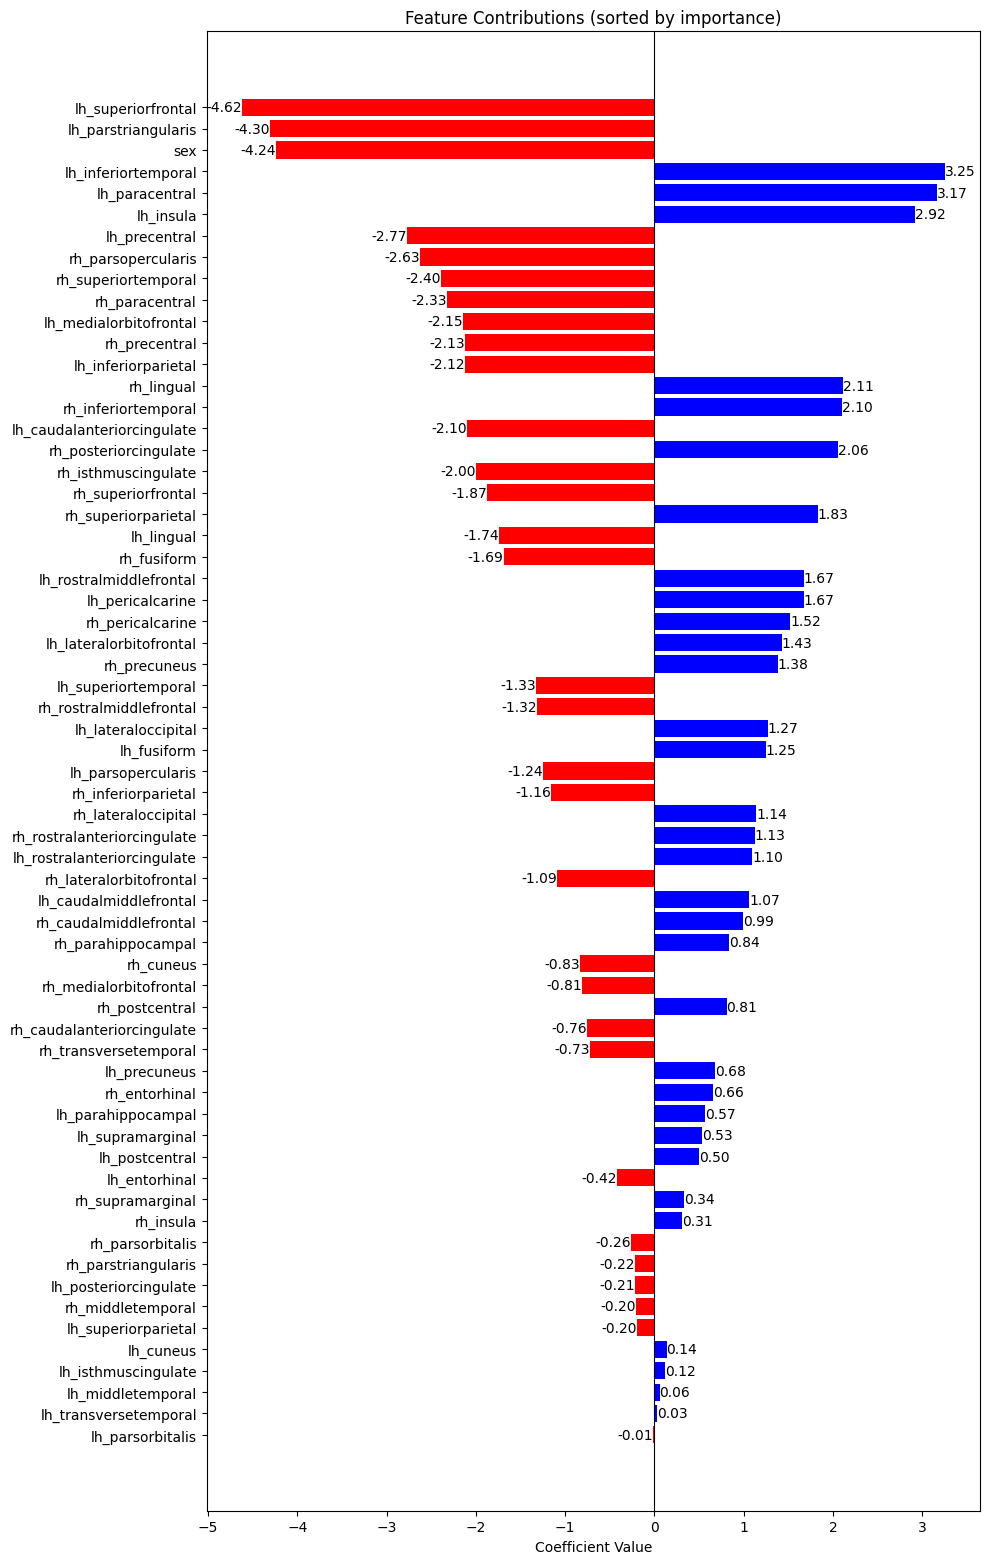

In [9]:
# Sort indices by absolute coefficient value 
coeff_sorted = np.argsort(np.abs(coefficients))

# Get all sorted features and coefficients
sorted_features = [all_fts[i] for i in coeff_sorted]
sorted_coeffs = coefficients[coeff_sorted]

# Plot horizontal bar chart
plt.figure(figsize=(10, max(6, len(sorted_features) * 0.25)))  # height scales with #features
bars = plt.barh(range(len(sorted_coeffs)), sorted_coeffs, 
                color=['red' if c < 0 else 'blue' for c in sorted_coeffs])

plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel("Coefficient Value")
plt.title("Feature Contributions (sorted by importance)")
plt.axvline(0, color='black', linewidth=0.8)

# Add coefficient labels on bars
for bar, coeff in zip(bars, sorted_coeffs):
    plt.text(bar.get_width(), 
             bar.get_y() + bar.get_height()/2,
             f"{coeff:.2f}", 
             ha='left' if coeff > 0 else 'right', 
             va='center')

plt.tight_layout()
plt.show()

We can see that one of the main drivers of the prediction is the sex. Why? We can have an easy intuition of that looking at the skewness of the data

In [10]:
print(train_set[train_set["sex"] == "Female"]["age"].mean(), train_set[train_set["sex"] == "Male"]["age"].mean())

df = train_set.copy()
sex01 = (df["sex"] == "Male").astype(int)     # 0=F, 1=M
r = np.corrcoef(sex01, df["age"])[0,1]        # point-biserial correlation
mF, mM = df.loc[df.sex=="Female","age"].mean(), df.loc[df.sex=="Male","age"].mean()
sF, sM = df.loc[df.sex=="Female","age"].std(ddof=1), df.loc[df.sex=="Male","age"].std(ddof=1)
nF, nM = df.sex.eq("Female").sum(), df.sex.eq("Male").sum()
sp = np.sqrt(((nF-1)*sF**2 + (nM-1)*sM**2) / (nF+nM-2))
d = (mF - mM) / sp
print("corr(sex, age) =", r, " |  Cohen's d(age by sex) =", d)

51.17686567164179 47.52734513274336
corr(sex, age) = -0.11165830829054588  |  Cohen's d(age by sex) = 0.22508148478649556


An intuition is that then sex is important as we are biasing the predictor due to the imbalance of sex/age. Let's take a look to the age distribution once again:

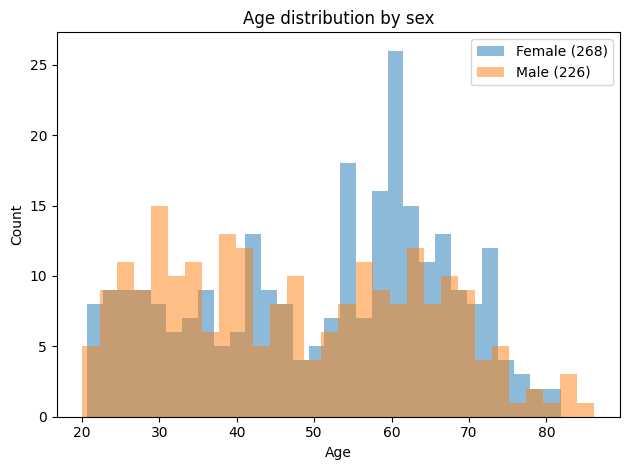

In [11]:
# Let's plot the age distribution to better visualize it
def plot_age_distribution_by(by=None, df=None):
    plt.figure()
    if by is None:
        plt.hist(df['age'], bins=30, edgecolor='black')
        plt.title('Age distribution')
    else:
        groups = df[by].unique()
        for g in groups:
            subset = df[df[by] == g]
            plt.hist(subset['age'], bins=30, alpha=0.5, label=f"{g} ({subset[by].count()})")
        plt.title(f'Age distribution by {by}')
        plt.legend()
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

plot_age_distribution_by("sex", df=train_set)

As we can see, female/male are not aligned. In particular, female has a more prominent age count. What if we then remove some sample?

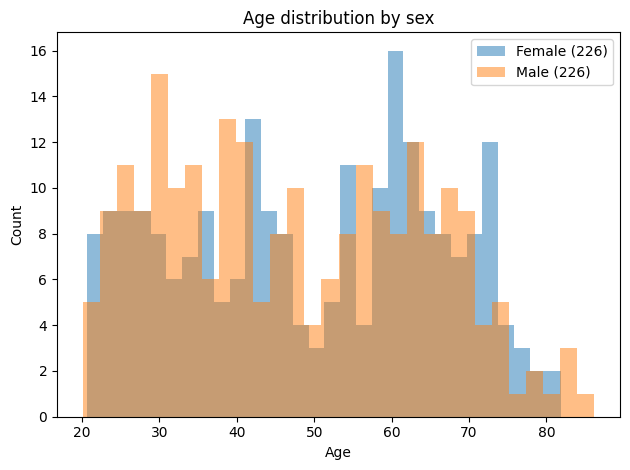

In [12]:
# We take the age range that is basically "bad"
age_min, age_max = 50, 70
spiky_subset = df[(df['age'] >= age_min) & (df['age'] <= age_max)]
# We define the 2 sexes
females = spiky_subset[spiky_subset['sex'] == 'Female']
males = spiky_subset[spiky_subset['sex'] == 'Male']
# ...and downsample them
females_down = females.sample(n=len(males), random_state=0)
balanced_train_set = pd.concat([females_down, males])
balanced_train_set = pd.concat([
    df[~((df['age'] >= age_min) & (df['age'] <= age_max))],
    balanced_train_set
])

plot_age_distribution_by("sex", df=balanced_train_set)

Let's see how this reflects to our predictor

In [13]:
# Evaluate
res_base = evaluate_models_with_cv(balanced_train_set, labels_features, include_scanner=False)
res_scanner = evaluate_models_with_cv(balanced_train_set, labels_features, include_scanner=True)
res_sex = evaluate_models_with_cv(balanced_train_set, labels_features, include_sex=True)
res_both = evaluate_models_with_cv(balanced_train_set, labels_features, include_scanner=True, include_sex=True)

print("Thickness only R²:", res_base["r2"], "MAE:", res_base["mae"])
print("Thickness + scanner R²:", res_scanner["r2"], "MAE:", res_scanner["mae"])
print("Thickness + sex R²:", res_sex["r2"], "MAE:", res_sex["mae"])
print("Thickness + scanner + sex R²:", res_both["r2"], "MAE:", res_both["mae"])

/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Thickness only R²: 0.4431386185257489 MAE: 10.18602709211906
Thickness + scanner R²: 0.4437043730168919 MAE: 10.194630293485382
Thickness + sex R²: 0.4554790003518201 MAE: 10.077419965542713
Thickness + scanner + sex R²: 0.45667743217752677 MAE: 10.057096597339802


In [14]:
res_sex["fitted_whole_model"]["reg"].coef_

array([-1.77002287,  1.07087852,  0.10114729, -0.75828081,  1.92525798,
       -1.77199717,  3.80623164,  2.67448863,  0.23562541,  1.48887188,
        1.79385776, -2.25083609, -2.35552979, -0.3486131 ,  3.3821157 ,
        0.23916433, -1.53102763, -0.21412126, -4.29609272,  1.90977928,
        0.69374309, -0.1061313 , -3.17277879,  0.36185369,  1.30973317,
        1.6614453 , -4.53946635, -0.34682621, -1.98606323,  0.32357529,
       -0.35675391, -0.90351452,  0.75347524, -0.53043682,  0.93639158,
       -2.27967225, -1.37363809,  2.23506836, -0.30047822, -1.87155262,
        0.46204907, -0.7917542 ,  2.37835827, -0.75270166,  0.00496906,
       -2.01310725,  0.99563936, -2.3660859 , -0.53430145, -0.47967355,
        1.61768548,  0.63157835,  2.03443407, -2.17749707,  1.05769039,
        1.48076177, -0.53068988, -2.76232195,  2.25981857, -1.38645717,
        0.24203165, -0.50667271, -3.33502577])

In [15]:
X_test_set = test_set[labels_features + ["sex"]]
y_test_set = test_set["age"].values

y_test_pred = res_sex["fitted_whole_model"].predict(X_test_set)
mae_m, mae_std = mae_fn(y_test_set.reshape(-1,1), y_test_pred.reshape(-1,1)) # Why mae? :)
r2 = r2_score(y_test_set, y_test_pred)
print(f"MAE (Test Set): {mae_m:.3f} +/- {mae_std:.3f}, R²: {r2:.3f}")

MAE (Test Set): 15.026 +/- 10.006, R²: -0.272


This is just an _informative_ example: we have dropped some of the samples which is something you should no do in practical settings. Also, we observe this phenomena on the coefficients due to reason that go beyond the simple imbalance. For instance, you may notice that:

- sex is on a different scale than corthical thickness (is, in fact, a dummy variable)
- we have a correlation between sex and corthical thickness 
- removing some age sample may have introduced an imbalance elsewhere (for instance, now some corthical thickness are overrepresented for a specific sex and a specific scanner and the estimator may have caught this relationship)

However, you can see that with a balanced dataset we have also an higher control on the intensity of the sex coefficient. 

The main takeway is that analysing the coefficient led us to notice a problem and allows us to do _informed_ decision on how to modify the model.

This is the main scope of explainability: shed light on the decision process of model to make them as trustable as possible.

For regression model, analysing coefficients is a straightforward way to get an insight on the decisions. However, this is not always the case. Non linear model may express coefficients that are no more easily understandable. Let's consider the Kernel Regression

In [16]:
def evaluate_models_with_cv_and_stratified_and_tune(df: pd.DataFrame,
                                            labels_features,
                                            include_scanner=False,
                                            include_sex=False,
                                            model_reg=None,
                                            n_splits=5,
                                            random_state=0,
                                            param_grid = None):
    # Add age_bin
    internal_df = df.copy()
    internal_df["age_bin"] = pd.cut(df["age"], bins=10, labels=False, include_lowest=True)
    internal_df["stratify_key"] = internal_df["age_bin"].astype(str) + "_" + internal_df["sex"].astype(str)
    
    if model_reg is None:
        model_reg = LinearRegression()

    covariates = []
    if include_scanner:
        covariates.append("scanner")
    if include_sex:
        covariates.append("sex")

    transformers = [("num", StandardScaler(), labels_features)]
    if covariates: # only if we have covariates we append
        transformers.append(
            ("cat", OneHotEncoder(drop="first", sparse_output=False), covariates)
        )

    preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")

    pipeline = Pipeline([
        ("preproc", preprocessor),
        ("reg", model_reg)
    ])

    X: pd.DataFrame = internal_df[labels_features + covariates]
    y = internal_df["age"].values

    outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    preds = np.zeros(len(y))

    eff_model = pipeline
    splits = list(outer_cv.split(np.arange(len(X)), internal_df["stratify_key"].values))

    if param_grid is not None:
        # Cv is used for estimating the best parameter for the model
        search = GridSearchCV(
            estimator=clone(pipeline),
            param_grid=param_grid,
            cv=splits,
            scoring="neg_mean_absolute_error",
            refit=True,
            n_jobs=1,
        )
        search.fit(X, y)
        eff_model = search.best_estimator_

    # We fit the (maybe best) model on the splits
    for (train_idx, val_idx) in splits:
        X_tr = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_tr = y[train_idx]
        y_val = y[val_idx]
        
        m = clone(eff_model)
        m.fit(X_tr, y_tr) # Refit
        preds[val_idx] = m.predict(X_val)

    return {
        "r2": r2_score(y, preds),
        "mae": mean_absolute_error(y, preds),
        "preds": preds,
        "fitted_whole_model": clone(eff_model).fit(X, y)
    }

PARAM_GRID = {
    "reg__alpha": [1e-4,1e-3,1e-2,1e-1,1],
    "reg__gamma": [1e-4,1e-3,1e-2,1e-1]
}

res_base = evaluate_models_with_cv_and_stratified_and_tune(train_set, labels_features, include_scanner=False, model_reg=KernelRidge(kernel="rbf"), param_grid=PARAM_GRID)
res_scanner = evaluate_models_with_cv_and_stratified_and_tune(train_set, labels_features, include_scanner=True, model_reg=KernelRidge(kernel="rbf"), param_grid=PARAM_GRID)
res_sex = evaluate_models_with_cv_and_stratified_and_tune(train_set, labels_features, include_sex=True, model_reg=KernelRidge(kernel="rbf"), param_grid=PARAM_GRID)
res_both = evaluate_models_with_cv_and_stratified_and_tune(train_set, labels_features, include_scanner=True, include_sex=True, model_reg=KernelRidge(kernel="rbf"), param_grid=PARAM_GRID)

print("Thickness only R²:", res_base["r2"], "MAE:", res_base["mae"])
print("Thickness + scanner R²:", res_scanner["r2"], "MAE:", res_scanner["mae"])
print("Thickness + sex R²:", res_sex["r2"], "MAE:", res_sex["mae"])
print("Thickness + scanner + sex R²:", res_both["r2"], "MAE:", res_both["mae"])

/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Thickness only R²: 0.4890461757036817 MAE: 9.555151472566344
Thickness + scanner R²: 0.4891704843642475 MAE: 9.555843315679773
Thickness + sex R²: 0.5011836345880301 MAE: 9.467215563661709
Thickness + scanner + sex R²: 0.5020261919703866 MAE: 9.458109516732518


In [17]:
res_sex["fitted_whole_model"]["reg"].dual_coef_

array([-7.35965223e+01, -1.46443672e+03, -6.46377488e+02, -1.43483870e+03,
       -1.15289201e+03, -1.84246371e+03, -1.06066470e+03, -4.43075610e+01,
       -1.41867955e+03, -1.58780554e+03, -2.10468214e+03, -7.62217191e+02,
       -9.30624908e+02, -1.60486122e+03,  1.23530605e+03, -3.83662549e+02,
        6.33060142e+02, -2.90166150e+02, -1.05341301e+03, -1.46353897e+03,
       -1.41897985e+02, -1.29658311e+03, -1.03582884e+03, -1.39231565e+02,
       -1.30872422e+03, -1.19351120e+03, -5.81908446e+02, -1.39077114e+03,
       -1.85141046e+03, -2.03208490e+03, -2.82564854e+02,  2.33761193e+02,
        4.15511141e+00,  1.06630148e+02, -1.76307786e+03,  1.37565301e+03,
       -1.21020246e+03, -6.11218303e+02, -2.27688510e+02,  4.30297750e+02,
       -9.58754789e+02,  5.22310639e+02, -6.32204174e+02, -1.82097299e+03,
        7.30535447e+01, -4.10991847e+02,  7.52119973e+02, -6.13276097e+02,
       -1.12075236e+03, -2.56492009e+03, -1.37927836e+03,  6.79540920e+02,
       -9.75518841e+02, -

As explained before, by nature Kernel Regression learns coefficients $\alpha_i$ that can be interpreted as how much the kernel derived from the sample $x_i$ contributes to the optimal final decision (that minimizes our loss function).

So, it does not _directly_ relate to the feature. However, it provides an information which can be interpreted differently, guiding how much our model relies on the single samples for outputting an optimal decision.

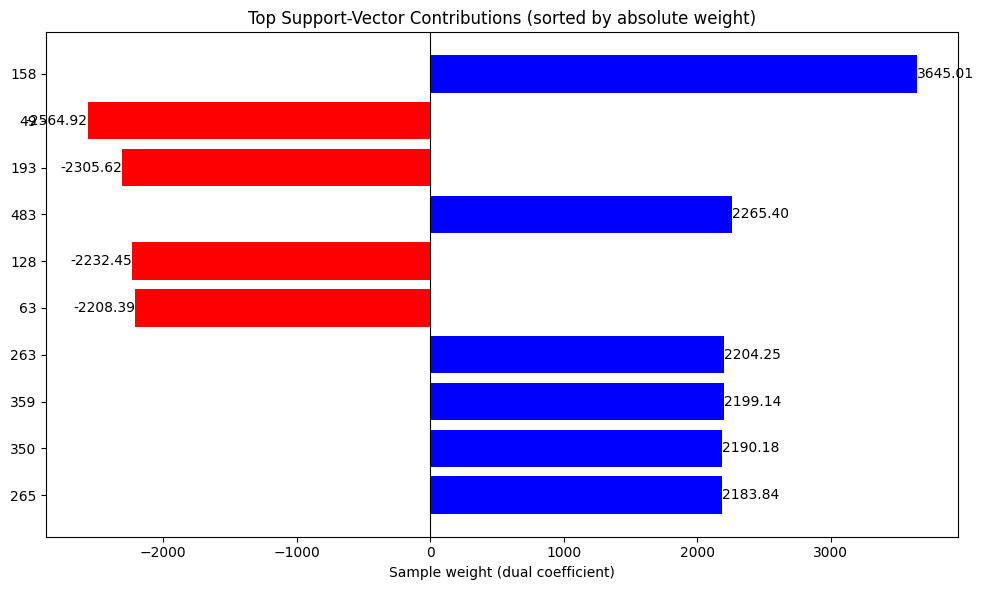

In [18]:
dual_coeffs = res_sex["fitted_whole_model"]["reg"].dual_coef_.ravel()  # shape: (n_support,)

order = np.argsort(np.abs(dual_coeffs))[::-1]

k = 10
top = order[:k]
coeff_top = dual_coeffs[top]
samples_top = np.arange(len(train_set))[top]  # these are indices in train_set for those SVs

# 4) Plot
y = np.arange(len(top))
plt.figure(figsize=(10, 6))
bars = plt.barh(y, coeff_top, color=['red' if c < 0 else 'blue' for c in coeff_top])

plt.yticks(y, samples_top)
plt.xlabel("Sample weight (dual coefficient)")
plt.title("Top Support-Vector Contributions (sorted by absolute weight)")
plt.axvline(0, color='black', linewidth=0.8)

for bar, coeff in zip(bars, coeff_top):
    x = bar.get_width()
    y_mid = bar.get_y() + bar.get_height()/2
    offset = 0.01 * np.sign(coeff) if coeff != 0 else 0.01
    plt.text(x + offset, y_mid, f"{coeff:.2f}",
             ha='left' if coeff >= 0 else 'right', va='center')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

For example, we could investigate on the nature of sample 158 and 49 in this case

In [19]:
train_set.iloc[samples_top]

,sample_id,subject_id,session,run,age,sex,scanner,site,diagnosis,dataset_name,...,rh_posteriorcingulate,rh_precentral,rh_precuneus,rh_rostralanteriorcingulate,rh_rostralmiddlefrontal,rh_superiorfrontal,rh_superiorparietal,rh_superiortemporal,rh_supramarginal,rh_transversetemporal
159,IXI185_1_1,IXI185,1,1,83.46,Male,Philips-1.5T,Guy’s-Hospital,Healthy,IXI,...,2.820738,2.617676,2.337835,3.008620,2.515043,2.811942,2.339970,3.052557,2.813436,2.143670
50,IXI064_1_1,IXI064,1,1,20.07,Male,Philips-1.5T,Guy’s-Hospital,Healthy,IXI,...,2.598609,2.669792,2.472304,2.687465,2.473087,2.869501,2.344048,3.081256,2.726443,2.677341
194,IXI226_1_1,IXI226,1,1,41.90,Female,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,...,2.374072,2.297599,2.270184,2.326892,2.324775,2.427560,2.101571,2.526850,2.553294,1.736794
549,IXI639_1_1,IXI639,1,1,86.20,Male,Philips-1.5T,Guy’s-Hospital,Healthy,IXI,...,2.551896,2.329326,2.170390,2.699584,2.189286,2.475057,1.956201,2.819005,2.389028,2.373766
129,IXI153_1_1,IXI153,1,1,22.43,Male,Philips-1.5T,Guy’s-Hospital,Healthy,IXI,...,2.490223,2.670834,2.319947,2.789490,2.468344,2.713049,2.138233,3.076307,2.624014,2.205395
64,IXI078_1_1,IXI078,1,1,28.51,Female,Philips-1.5T,Guy’s-Hospital,Healthy,IXI,...,2.551217,2.477402,2.374232,2.770838,2.578972,2.843719,2.262427,3.088369,2.795911,2.365130
284,IXI327_1_1,IXI327,1,1,73.56,Male,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,...,2.341492,2.596301,2.233497,2.676799,2.371612,2.574451,2.195186,3.026949,2.687759,2.249851
397,IXI458_1_1,IXI458,1,1,70.71,Male,Philips-1.5T,Guy’s-Hospital,Healthy,IXI,...,2.726123,2.741199,2.674767,3.149632,2.470944,2.897725,2.409883,3.250071,2.805207,2.579716
388,IXI448_1_1,IXI448,1,1,79.41,Male,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,...,2.618786,2.296445,2.160813,2.740014,2.572247,2.639678,2.139952,2.752182,2.401460,1.971724
286,IXI329_1_1,IXI329,1,1,55.66,Male,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,...,2.469252,2.542203,2.313576,2.873404,2.550848,2.868120,2.125130,3.173568,2.590398,1.946228


Further analysis may be conducted to understand why this samples are very important.

One consideration for instance may be that these sample are somewhat unique (especially the old samples) both in terms of categorical feature or distribution of specific values of their corthical thickness. It is especially hard to show this (for instance one may plot the average distribution of all the corthical thickenss and understand if that sample present unique/outlying values).

But as before we are more interested in the impact of single feature (which corthical thickness is important?). It is in practice possible to understand the contribution (called _global contribution_) by performing a so called _importance permutation_ (IP).

The idea of IP is to quantifies the contribution of each feature to the model decision by randomly shuffling the feature's values and observing the resulting decrease in the model's score. 

This kind of approach is practically implemented in `sklearn`

In [20]:
whole_model = res_sex["fitted_whole_model"]
y_test_pred = whole_model.predict(test_set)
mae_m, mae_std = mae_fn(y_test_set, y_test_pred)
r2 = r2_score(y_test_set, y_test_pred)
print(f"Naive linear regression MAE: {mae_m:.3f} +/- {mae_std:.3f}, R²: {r2:.3f}")

Naive linear regression MAE: 13.114 +/- 7.931, R²: 0.083


In [21]:
# It is important we scale the features before feeding it to the permutation importance!
X_test_scaled = res_sex["fitted_whole_model"]["preproc"].transform(test_set[labels_features + ["sex"]])
X_test_scaled

array([[-0.17052194, -1.14360421, -0.52726525, ..., -1.22362612,
         0.15040422,  0.        ],
       [ 1.64323077,  0.44335779,  0.31163874, ...,  1.24964487,
         1.05144447,  0.        ],
       [-1.22387731,  1.32619473,  1.84610879, ..., -0.06638985,
         1.67535741,  0.        ],
       ...,
       [-1.1184941 ,  0.68243741,  0.32257572, ...,  0.14685672,
         1.10106165,  0.        ],
       [ 1.48475507,  0.75929106, -0.84745883, ...,  1.00803731,
         2.02814255,  1.        ],
       [ 1.02217315,  0.69300195,  1.5134219 , ...,  0.77736357,
         0.76262066,  0.        ]])

In [22]:
perm = permutation_importance(res_sex["fitted_whole_model"]["reg"], X_test_scaled, y_test_set, n_repeats=30, random_state=0, n_jobs=None)
perm_importances = pd.Series(perm.importances_mean, index=[label for label in (labels_features + ["sex"])]).sort_values(ascending=False)

In [23]:
perm_importances

lh_parstriangularis      0.074743
rh_inferiortemporal      0.054861
rh_isthmuscingulate      0.053001
lh_inferiorparietal      0.046022
lh_superiorfrontal       0.042075
                           ...   
rh_postcentral          -0.009191
rh_lingual              -0.010111
rh_posteriorcingulate   -0.011911
rh_pericalcarine        -0.015824
lh_pericalcarine        -0.022535
Length: 63, dtype: float64

We see that this model share similar importance to the regression model, and it is interesting to see that the order is not always the same! In fact, this is not surprising: each model operates in different way, and gives different importance to each feature!

Other models were designed to provide an intuition of the features importance when trying to explain the model. For instance, XGBoost is an example of a non linear model that provides this kind of information

In [24]:
nr.seed(0)

def evaluate_xgboost_with_cv_and_stratified_and_tune_rand(df: pd.DataFrame,
                                            labels_features,
                                            include_scanner=False,
                                            include_sex=False,
                                            model_reg=None,
                                            n_splits=5,
                                            random_state=0,
                                            param_grid = None):
    # Add age_bin
    internal_df = df.copy()
    internal_df["age_bin"] = pd.cut(df["age"], bins=10, labels=False, include_lowest=True)
    internal_df["stratify_key"] = internal_df["age_bin"].astype(str) + "_" + internal_df["sex"].astype(str)

    covariates = []
    if include_scanner:
        covariates.append("scanner")
    if include_sex:
        covariates.append("sex")

    for c in covariates:
        internal_df[c] = internal_df[c].astype("category")

    pipeline = Pipeline([
        ("reg", model_reg)
    ])

    X: pd.DataFrame = internal_df[labels_features + covariates].copy()
    y = internal_df["age"].values

    inner_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state+1)
    eff_model = pipeline
    splits = list(inner_cv.split(np.arange(len(X)), internal_df["stratify_key"].values))

    if param_grid is not None:
        # Cv is used for estimating the best parameter for the model
        search = RandomizedSearchCV(
            estimator=clone(pipeline),
            param_distributions=param_grid,
            n_iter=100,
            cv=splits,
            scoring="neg_mean_absolute_error",
            refit=True,
            n_jobs=-1,
            random_state=random_state,
            verbose=1,
        )
        search.fit(X, y)
        eff_model = search.best_estimator_

    # We fit the (maybe best) model on the splits
    outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    outer_splits = list(outer_cv.split(np.arange(len(X)), internal_df["stratify_key"].values))
    preds = np.zeros(len(y))

    def check_min_count(labels, min_count=2):
        counts = Counter(labels)
        return None if min(counts.values()) < min_count else labels

    for (train_idx, val_idx) in outer_splits:
        X_tr = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_tr = y[train_idx]
        y_val = y[val_idx]

        # Fit with a little internal cv for early stopping
        m_es = clone(eff_model)
        m_es.set_params(
            reg__n_estimators=2000, # <- we set this high to limit
            reg__early_stopping_rounds=50,
            reg__eval_metric="mae"
        )

        strat_for_holdout = check_min_count(internal_df.iloc[train_idx]["stratify_key"], min_count=2)
        X_trn, X_hold, y_trn, y_hold = train_test_split(
            X_tr, y_tr, test_size=0.1,
            stratify=strat_for_holdout,
            random_state=random_state
        )

        m_es.fit(X_trn, y_trn, reg__eval_set=[(X_hold, y_hold)], reg__verbose=False)
        # We pick the best iteration
        best_iter = m_es["reg"].get_booster().best_iteration
        # We create a new model with the precise number of estimators and no early stopping
        m = clone(eff_model)
        m.set_params(reg__n_estimators=best_iter + 1,
             reg__early_stopping_rounds=None)
        m.fit(X_tr, y_tr) # Refit on the whole training set
        # Get the predictions
        preds[val_idx] = m.predict(X_val)

    # We do a similar thing to refit the whol model
    final_model_es = clone(eff_model)
    final_model_es.set_params(
            reg__n_estimators=2000, # <- we set this high to limit
            reg__early_stopping_rounds=50,
            reg__eval_metric="mae"
        )
    strat_for_holdout = check_min_count(internal_df["stratify_key"], min_count=2)
    X_trn, X_hold, y_trn, y_hold = train_test_split(
        X, y, test_size=0.1,
        stratify=strat_for_holdout,
        random_state=random_state
    )
    final_model_es.fit(X_trn, y_trn, reg__eval_set=[(X_hold, y_hold)], reg__verbose=False)
    best_iter_fm = final_model_es["reg"].get_booster().best_iteration
    # We create a new model with the precise number of estimators and no early stopping
    final_model = clone(eff_model)
    final_model.set_params(reg__n_estimators=best_iter_fm + 1,
            reg__early_stopping_rounds=None)
    final_model.fit(X, y) # Refit on the whole training set

    return {
        "r2": r2_score(y, preds),
        "mae": mean_absolute_error(y, preds),
        "preds": preds,
        "fitted_whole_model": final_model
    }

xg_boost_model = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    enable_categorical=True,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=0,
    n_jobs=1,
    device="cuda"
)

PARAM_GRID_XGB = {
    "reg__max_depth": randint(3, 9),
    "reg__learning_rate": uniform(0.02, 0.12),
    "reg__subsample": uniform(0.6, 0.4),
    "reg__colsample_bytree": uniform(0.6, 0.4),
    "reg__min_child_weight": randint(1, 7),
    "reg__gamma": uniform(0.0, 1.0),
    "reg__reg_alpha": uniform(0.0, 0.5),
    "reg__reg_lambda": uniform(0.5, 9.5),
    "reg__objective": ["reg:squarederror", "reg:pseudohubererror"]
}


# res_base = evaluate_models_with_cv_and_stratified_and_tune(train_set, labels_features, include_scanner=False, model_reg=xg_boost_model, param_grid=PARAM_GRID_XGB)
# res_scanner = evaluate_models_with_cv_and_stratified_and_tune(train_set, labels_features, include_scanner=True, model_reg=xg_boost_model, param_grid=PARAM_GRID_XGB)
res_sex = evaluate_xgboost_with_cv_and_stratified_and_tune_rand(train_set, labels_features, include_sex=True, model_reg=xg_boost_model, param_grid=PARAM_GRID_XGB)
# res_both = evaluate_models_with_cv_and_stratified_and_tune(train_set, labels_features, include_scanner=True, include_sex=True, model_reg=xg_boost_model, param_grid=PARAM_GRID_XGB)

# print("Thickness only R²:", res_base["r2"], "MAE:", res_base["mae"])
# print("Thickness + scanner R²:", res_scanner["r2"], "MAE:", res_scanner["mae"])
print("Thickness + sex R²:", res_sex["r2"], "MAE:", res_sex["mae"])
# print("Thickness + scanner + sex R²:", res_both["r2"], "MAE:", res_both["mae"])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/fsammarco/.local/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [14:13:44] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/fsammarco/.local/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [14:13:44] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might 

KeyboardInterrupt: 

In [ ]:
# Save the model
# res_sex["fitted_whole_model"]["reg"].save_model("../checkpoints/XGBoost_best_model.json")

In [25]:
# I already trained the model we load it
xg_boost_model = XGBRegressor()
xg_boost_model.load_model("../checkpoints/XGBoost_best_model.json")
xg_boost_model

XGBRegressor(base_score='4.9507248E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'floa...
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

We can plot the importance of the features for the model

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

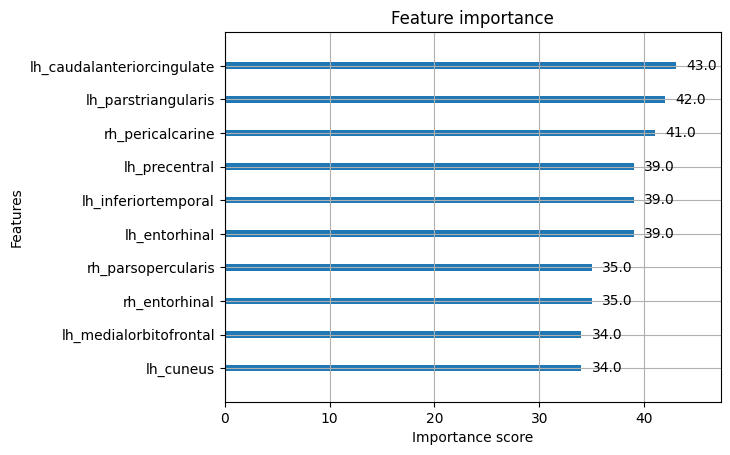

In [26]:
bst = xg_boost_model.get_booster()
plot_importance(bst, max_num_features=10)

There is a consensus on some of the values for the two models, though we can see that some of them diverge
Let's see how much sex is important

In [27]:
bst.get_fscore()

{'lh_caudalanteriorcingulate': 43.0,
 'lh_caudalmiddlefrontal': 31.0,
 'lh_cuneus': 34.0,
 'lh_entorhinal': 39.0,
 'lh_fusiform': 29.0,
 'lh_inferiorparietal': 27.0,
 'lh_inferiortemporal': 39.0,
 'lh_insula': 25.0,
 'lh_isthmuscingulate': 26.0,
 'lh_lateraloccipital': 16.0,
 'lh_lateralorbitofrontal': 15.0,
 'lh_lingual': 13.0,
 'lh_medialorbitofrontal': 34.0,
 'lh_middletemporal': 24.0,
 'lh_paracentral': 12.0,
 'lh_parahippocampal': 24.0,
 'lh_parsopercularis': 29.0,
 'lh_parsorbitalis': 17.0,
 'lh_parstriangularis': 42.0,
 'lh_pericalcarine': 26.0,
 'lh_postcentral': 23.0,
 'lh_posteriorcingulate': 20.0,
 'lh_precentral': 39.0,
 'lh_precuneus': 10.0,
 'lh_rostralanteriorcingulate': 26.0,
 'lh_rostralmiddlefrontal': 15.0,
 'lh_superiorfrontal': 26.0,
 'lh_superiorparietal': 7.0,
 'lh_superiortemporal': 16.0,
 'lh_supramarginal': 12.0,
 'lh_transversetemporal': 20.0,
 'rh_caudalanteriorcingulate': 25.0,
 'rh_caudalmiddlefrontal': 20.0,
 'rh_cuneus': 15.0,
 'rh_entorhinal': 35.0,
 'rh

Interestingly enough, for XGBoost sex is the least important feature!

In [28]:
test_set_mod = test_set[labels_features + ["sex"]].copy()
test_set_mod["sex"] = test_set_mod["sex"].astype("category")

y_test_pred = xg_boost_model.predict(test_set_mod)
mae_m, mae_std = mae_fn(y_test_set, y_test_pred)
r2 = r2_score(y_test_set, y_test_pred)
print(f"XGBoost MAE: {mae_m:.3f} +/- {mae_std:.3f}, R²: {r2:.3f}")

XGBoost MAE: 13.906 +/- 7.888, R²: 0.002


# Post-Hoc

Post-Hoc methods are used for more black-box models, where it is not really possible to extract explanations directly as we did now.

In simple word, a post-hoc method act on the specific model we are considering and apply a mathematical method to obtain a comprhensible explanations from it.

Let's try to apply this method to the MLP we trained in the previous session

In [29]:
SEED = 0
nr.seed(SEED)
th.manual_seed(SEED)
th.cuda.manual_seed_all(SEED)

In [30]:
class MLPCort(nn.Module):
    def __init__(self, in_dim: int, hidden: List[int], dropout: float = 0.0):
        super().__init__()
        layers: List[nn.Module] = []
        prev = in_dim
        for h in hidden:
            layers += [
                nn.Linear(prev, h),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout),
            ]
            prev = h
        layers += [nn.Linear(prev, 1)]  # regression output
        self.net = nn.Sequential(*layers)

    def forward(self, x: th.Tensor) -> th.Tensor:
        return self.net(x)
    
# Dataset
class CorthicalThicknessDataset(Dataset):
    def __init__(self,
                 metadata_df: pd.DataFrame,
                 features: List[str],
                 transform = None,
                 age_transforms = None):
        self.df = metadata_df
        self.transform = transform
        self.age_transforms = age_transforms
        self.features = features

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row: pd.Series = self.df.iloc[idx]
        age = float(row["age"])
        features = row[self.features].values.astype(np.float32)
        if self.transform:
            features = self.transform(features)
        if self.age_transforms:
            age = self.age_transforms(age)
        return {
            "cort": features if th.is_tensor(features) else th.as_tensor(features),
            "age": (age if th.is_tensor(age) else th.as_tensor(age)).type(dtype=th.float32),
        }

labels_features = [c for c in train_set.columns if "lh" in c or "rh" in c] 

def apply_scaler(df, scaler, num_cols):
    df_scaled = df.copy()
    df_scaled[num_cols] = scaler.transform(df[num_cols])
    return df_scaled

def get_loaders_thk(train_set,
                    val_set,
                    features,
                    train_transforms=None,
                    val_transforms=None,
                    age_transforms=None,
                    batch_size=16):

    # Scale the corthical thicknesses 
    scaler = StandardScaler()
    scaler.fit(train_set[features])

    train_scaled = apply_scaler(train_set, scaler, features)
    val_scaled   = apply_scaler(val_set, scaler, features)

    ds_tr = CorthicalThicknessDataset(
        train_scaled,
        features=features,
        transform=train_transforms,
        age_transforms=age_transforms
    )

    train_dl = DataLoader(ds_tr, batch_size=batch_size,
                            shuffle=True,
                            num_workers=6,
                            pin_memory=True,
                            persistent_workers=True,
                            prefetch_factor=2)
    
    ds_val = CorthicalThicknessDataset(
        val_scaled,
        features=features,
        transform=val_transforms,
        age_transforms=age_transforms
    )
    val_dl = DataLoader(ds_val, batch_size=batch_size,
                            num_workers=2,
                            pin_memory=False,
                            persistent_workers=True,
                            prefetch_factor=None)
                            # persistent_workers=True,
                            # prefetch_factor=2)

    return train_dl, val_dl, scaler

In [33]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print('Using device:', device)

mlpcort = MLPCort(
        in_dim=len(labels_features),
        hidden=[32,64,16],
        dropout=0.3
).to(device=device)

state_dict = th.load("../checkpoints/MLPCort_best_model.pth")
mlpcort.load_state_dict(state_dict["model_state_dict"])

mlpcort

Using device: cuda


MLPCort(
  (net): Sequential(
    (0): Linear(in_features=62, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=16, out_features=1, bias=True)
  )
)

We will investigate now some methods that allow us to explain feature importance (i.e. corthical thickness for our MLP)

The importance for black box model can in general be called _attribution_ and measure the contribution of a certain feature $x_i$ with respect to a baseline $x_i'$. For instance, a baseline can be a specific corthical thickness fold of value 0, and the attribution may measure how the predicted age changes as the cortical thickness value is increased from the baseline to a value $\delta$.

In [ ]:
# let's create the dataloaders
_, test_dl, _ = get_loaders_thk(
    train_set=train_set, val_set=test_set, features=labels_features,
    age_transforms=lambda x: x/255., batch_size=32
)

In [ ]:
@th.no_grad() # <- note, this is not needed in the actual attribution computation!
def build_methods(model: nn.Module):
    return {
        "input_x_gradient": InputXGradient(model),
        "integrated_gradients": IntegratedGradients(model),
        "feature_ablation": FeatureAblation(model),
        "shapley_sampling": ShapleyValueSampling(model),
    }

In [ ]:
def attr_input_x_gradient(method, x: th.Tensor) -> th.Tensor:
    # For regression with single output neuron → target=0
    x = x.detach().requires_grad_(True)
    return method.attribute(x, target=0)

def attr_integrated_gradients(method, x: th.Tensor, baselines: th.Tensor,
                              n_steps: int = 128, internal_bs: int | None = None) -> th.Tensor:
    x = x.detach().requires_grad_(True)
    return method.attribute(
        x, target=0, baselines=baselines, n_steps=n_steps,
        internal_batch_size=internal_bs
    )

def attr_integrated_gradients_smooth(method, x: th.Tensor, baselines: th.Tensor,
                                     n_steps: int = 64, nt_samples: int = 15,
                                     nt_type: str = "smoothgrad_sq",
                                     stdevs: float = 0.01,
                                     internal_bs: int | None = None) -> th.Tensor:
    x = x.detach().requires_grad_(True)
    # NoiseTunnel wraps IG; pass nt-specific args here
    return method.attribute(
        x, target=0, baselines=baselines, n_steps=n_steps,
        nt_samples=nt_samples, nt_type=nt_type, stdevs=stdevs,
        internal_batch_size=internal_bs
    )

def attr_feature_ablation(method, x: th.Tensor, feature_mask: th.Tensor,
                          perturbations_per_eval: int = 64) -> th.Tensor:
    # Ablate (set to baseline=0) each feature group defined in feature_mask
    # For standardized inputs, 0 ≈ average subject.
    return method.attribute(
        x, target=0, feature_mask=feature_mask,
        perturbations_per_eval=perturbations_per_eval
    )

def attr_shapley_sampling(method, x: th.Tensor, feature_mask: th.Tensor,
                          n_samples: int = 200, show_progress: bool = False) -> th.Tensor:
    # Monte-Carlo Shapley values (expensive). n_samples trades accuracy vs. speed.
    return method.attribute(
        x, target=0, feature_mask=feature_mask,
        n_samples=n_samples, show_progress=show_progress
    )

In [ ]:
def ensure_2d(x: th.Tensor) -> th.Tensor:
    # Make sure x is [B, in_dim]
    if x.ndim == 1:
        x = x.unsqueeze(0)
    return x

def get_attribution(test_dl, storage, method, method_name, *args, **kwargs):
    # Utility function to register the attribution.
    mlpcort.eval()
    for batch in test_dl:
        x: th.Tensor = ensure_2d(batch["cort"].float()).to(device=device)  # [B, F]

        attribution = method(x, *args, **kwargs)
        storage[method_name].append(attribution.detach().cpu().numpy())
        return attribution

In [ ]:
in_dim = len(labels_features)
methods = build_methods(mlpcort)
# for each method, we create a storage of the attributions
storage = {m: [] for m in methods}

# Input x Gradients

The gradients are a simple proxy for understanding the decision of a black box model. In fact, gradients measure the variation of our output function (the age) with respect to the input we gave to the model. So, they are the most simple attribution method.

The classical technique used for explaining a bb model is then to propagate the gradient of the output all the way to the input, using the classical chaining rule and obtaining the final attribution.

In [ ]:
name_mthd = "input_x_gradient"
def calc_input_x_gradient(x):
    # For regression with single output neuron → target=0
    x = x.detach().requires_grad_(True)
    return methods[name_mthd].attribute(x, target=0)

get_attribution(test_dl, storage, calc_input_x_gradient, name_mthd)
storage[name_mthd]

[array([[ 4.0760431e-05,  5.7236361e-03, -1.4091843e-03, ...,
          2.0194699e-03, -2.5037013e-03,  5.3517160e-04],
        [-5.3452943e-03, -1.8409871e-03,  8.0984231e-04, ...,
          4.4704837e-05, -2.2177370e-03,  2.7675324e-03],
        [ 2.3959002e-04, -7.5727650e-03,  7.0445174e-03, ...,
         -5.3472177e-05, -3.3503500e-05,  5.4356400e-03],
        ...,
        [ 4.6611358e-03, -4.6611982e-03, -8.2254555e-04, ...,
         -5.9761129e-05, -5.0292147e-04,  6.3030492e-04],
        [-1.1346074e-03, -9.4361091e-04, -1.7019245e-03, ...,
         -5.8901855e-03,  3.9626559e-04, -2.4247568e-04],
        [-4.3747816e-03, -2.4331375e-03, -1.4843524e-03, ...,
         -2.6475890e-03, -1.4767910e-03,  2.0093631e-03]], dtype=float32)]

In [ ]:
storage[name_mthd][0].shape # <- it gives us a weight for each different sample/feature value

(32, 62)

# Integrated Gradients

It is an evolution on the calculation of the classical input x gradient. Gradients suffers from many problems: they are highly unstable, and they suffer from a very specific problem where changes of the function directly related to the input are untracked due to the nature of the non-linear function inside the network.

To see this problem, we can consider a case of the output of a network with the ReLU function.

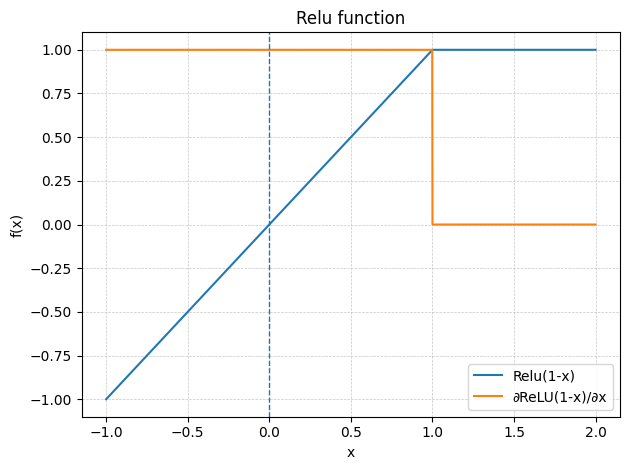

In [ ]:
x = np.linspace(-1, 2, 2000)

# ReLU function
relu = 1 - np.maximum(0, 1-x)
grad = np.where((1-x) > 0, 1, 0)

plt.figure()
plt.plot(x, relu, label="Relu(1-x)")
plt.plot(x, grad, label="∂ReLU(1-x)/∂x")
plt.axvline(0, linestyle="--", linewidth=1)
plt.title("Relu function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

We can see that:

- $x = 0 \rightarrow f(x) = 1-ReLu(1-x) = 1$
- $x = 2 \rightarrow f(x) = 1-ReLu(1-x) = 0$

Since the input is 2, the gradient we calculate is 0. Thus, we are giving to the input an attribution:

$x * grad = 2 * 0 = 0$

However, we would have expected the attribution to be not 0, since the input has caused the change of the final function! If the x would have been a cortichal thickness value, it for sure would have lead to a different age prediction. Ideally, the method should have returned a correct attribution, but this is not the case (more on this counterintuive example: https://arxiv.org/pdf/1703.01365, which also introduce a broader discussion on IG).

IG solves this issue by considering by considering how $f(x)$ changes when our sample changes not instantaneously, but along a specific "change path" from the baseline $x_i'$ to the sample $x_i$. Then, instead of multiplying for the input, we quantify the attribution as the multiplication of the calculated "integrated" gradient with the difference in the input.

In [ ]:
name_mthd = "integrated_gradients"
def calc_intgrad(x, baselines, n_steps, batch_size):
    # we must define a baselines, and how much discrete steps of the path we execute. Trivially, if steps = 1, we calculate gradient * input!
    x = x.detach().requires_grad_(True)
    return methods[name_mthd].attribute(
        x, target=0, baselines=baselines, n_steps=n_steps,
        internal_batch_size=batch_size
    )

# We provide a zeroed baseline
baseline = th.zeros(32, in_dim, device=device)
get_attribution(test_dl, storage, calc_intgrad, name_mthd, baselines=baseline, n_steps=100, batch_size=32)
storage[name_mthd]

[array([[ 1.04967905e-04,  6.64095301e-03, -1.77666638e-03, ...,
          1.39298069e-03, -8.35920277e-04,  4.90238308e-04],
        [-9.58461221e-03, -3.14776110e-03,  1.16846839e-03, ...,
          1.42259771e-04, -2.89860717e-03,  4.27072169e-03],
        [ 4.51048865e-04, -9.54196602e-03,  7.15989992e-03, ...,
          2.68156786e-04, -4.93180232e-05,  6.40856475e-03],
        ...,
        [ 2.49471026e-03, -3.53128533e-03, -6.58779696e-04, ...,
         -5.00974311e-05,  3.85685016e-05,  3.98977456e-04],
        [-1.12160621e-03, -1.30430108e-03,  1.01144495e-03, ...,
         -4.65784688e-03,  2.91449454e-04, -5.19067049e-04],
        [-9.32780840e-03, -5.02436049e-03,  2.58106459e-03, ...,
         -3.15981777e-03, -3.45108192e-03,  4.05589398e-03]], dtype=float32)]

# Feature Ablation

Feature ablation tries to change the vision of attribution by interpreting it in terms of "removal" of feature. Basically, instead of measuring the gradient, it measure the difference in the output when a specific set of feature is replaced by a baseline. The difference is the attribution.

In [ ]:
name_mthd = "feature_ablation"
def calc_fa(x, feature_mask, baselines, in_dim):
    # The feature mask is the set of features to consider
    x = x.detach().requires_grad_(True)
    return methods[name_mthd].attribute(
        x, target=0, baselines=baselines, feature_mask=feature_mask,
        perturbations_per_eval=min(64, in_dim)
    )

# When feature
baseline = th.zeros(32, in_dim, device=device)
get_attribution(test_dl, storage, calc_fa, name_mthd, feature_mask=None, baselines=None, in_dim=in_dim)
storage[name_mthd]

[array([[-8.6322427e-05,  5.1402450e-03, -8.9834630e-04, ...,
          1.3833642e-03, -6.7475438e-04,  5.1826239e-04],
        [-5.1079988e-03, -1.8409938e-03,  8.0983341e-04, ...,
          4.4703484e-05, -2.1867007e-03,  2.7880520e-03],
        [-3.7935376e-04, -6.8260133e-03,  7.3020160e-03, ...,
         -2.5147200e-04, -3.3497810e-05,  5.1961243e-03],
        ...,
        [ 3.4579039e-03, -4.2444766e-03, -8.2254410e-04, ...,
         -5.9768558e-05, -5.0292909e-04,  6.1999261e-04],
        [-1.0391474e-03, -1.1517853e-03, -1.7717481e-05, ...,
         -7.5461268e-03,  3.9626658e-04, -2.5625527e-04],
        [-4.9751252e-03, -2.5951564e-03, -1.2431443e-03, ...,
         -2.4798661e-03, -1.9360185e-03,  1.3400242e-03]], dtype=float32)]

# Shapley values

Finally, Shapley values is a mathematical rigorous method to calculate the attribution of a feature. A shapley value assigned for a feature represent how much such feature contributed to the final value of the output function when considered considered along all possible sets of all the other features. Imagine it in this way: we say that a corthical thickness $x_i$ has a shapley value $\phi_i$ when the contribution that it has towards the defition of the age when considered for all its different values and with all different subset of corthical thickness features is averaged. 

For continuous variable such as corthical thickness, it is ill-posed to compute such quantity (what is absence of a continuous variable?). Moreover for black model is also intractable, since we would need to encode in the model the absence and the presence of the feature over all possible sets of the other features. A number of model which is infeasible to obtain.

A relax to calculate the Shapley value is defining the absence of a feature as a baseline or the "zero" value. Then, to solve the computational burden, contribution is calculated over a randomly sampled subset of features. This is called the _Sampling Shapley_.

In [ ]:
name_mthd = "shapley_sampling"
def calc_shap(x, baselines, n_samples):
    # we must define a baselines, and how much discrete steps of the path we execute. Trivially, if steps = 1, we calculate gradient * input!
    x = x.detach().requires_grad_(True)
    return methods[name_mthd].attribute(
        x, target=0, baselines=baselines,
        n_samples=n_samples, show_progress=True)

# We provide a zeroed baseline
get_attribution(test_dl, storage, calc_shap, name_mthd, baselines=None, n_samples=1000)
storage[name_mthd]

Shapley Value Sampling attribution:   0%|          | 0/62001 [00:00<?, ?it/s]

[array([[ 1.3687032e-04,  6.4109308e-03, -1.4838139e-03, ...,
          2.0183173e-03, -1.2813200e-03,  3.9446229e-04],
        [-7.4913921e-03, -2.6443454e-03,  9.0223557e-04, ...,
          1.6000724e-04, -2.6207697e-03,  2.8620327e-03],
        [ 1.9013191e-03, -8.7785330e-03,  6.0875770e-03, ...,
          4.0975012e-04,  3.1320618e-05,  5.0324700e-03],
        ...,
        [ 3.7373917e-03, -3.2461821e-03, -8.5527665e-04, ...,
         -2.9104427e-05, -9.5454503e-05,  3.9961733e-04],
        [-1.3605104e-03, -1.3246600e-03,  1.1896462e-03, ...,
         -4.9382118e-03,  3.0128795e-04, -5.1471882e-04],
        [-8.4409630e-03, -3.8659524e-03,  3.5397282e-03, ...,
         -2.6482246e-03, -4.0273899e-03,  2.4359140e-03]], dtype=float32)]

In [ ]:
# For each method, we see the top features

for method_name, chunks in storage.items():
    if not chunks:
        continue
    A = np.concatenate(chunks, axis=0)  # [N, F]
    assert A.shape[1] == in_dim

    # Global importances = mean absolute attribution over test set
    glob = np.mean(np.abs(A), axis=0)
    gi = (
        pd.DataFrame({"feature": labels_features, "importance": glob})
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )
    gi["rank"] = gi.index + 1

    # Quick top-k printout
    topk = gi.head(min(len(gi), 10))
    print(f"\n[Method: {method_name}] Top {len(topk)} features by mean |attribution| on TEST set:")
    for _, r in topk.iterrows():
        print(f"  #{int(r['rank']):2d}  {r['feature']}: {r['importance']:.6f}")


[Method: input_x_gradient] Top 10 features by mean |attribution| on TEST set:
  # 1  lh_medialorbitofrontal: 0.007520
  # 2  rh_medialorbitofrontal: 0.006280
  # 3  lh_inferiortemporal: 0.005599
  # 4  lh_lateralorbitofrontal: 0.004923
  # 5  lh_pericalcarine: 0.004208
  # 6  lh_isthmuscingulate: 0.003931
  # 7  lh_lateraloccipital: 0.003402
  # 8  rh_pericalcarine: 0.003304
  # 9  lh_parstriangularis: 0.003049
  #10  rh_precentral: 0.003048

[Method: integrated_gradients] Top 10 features by mean |attribution| on TEST set:
  # 1  lh_medialorbitofrontal: 0.011824
  # 2  rh_medialorbitofrontal: 0.010246
  # 3  lh_lateralorbitofrontal: 0.008421
  # 4  lh_inferiortemporal: 0.007352
  # 5  lh_pericalcarine: 0.006361
  # 6  rh_pericalcarine: 0.005452
  # 7  lh_parstriangularis: 0.005243
  # 8  rh_lateralorbitofrontal: 0.005096
  # 9  rh_precentral: 0.005014
  #10  lh_rostralmiddlefrontal: 0.004897

[Method: feature_ablation] Top 10 features by mean |attribution| on TEST set:
  # 1  lh_media

For the model that acts better on the test set, it seems the most important feature are almost consistent in each method. We see some corthical thickness measure we also obtained from the classical models, however we have very different behaviours. This is normal: each model catches up different trends in the data, and it happens that the MLP has caught some non-linear complex trend not seen in the other models.

It is also possible to apply these methods to the brain MRIs, although much more complex and time consuming. We can give a quick example using one of the simple models we obtained in the CNN lesson part.

# Layer Relevance Propagation

LRP is a very popular method for feature attribution for images. The idea is that the attribution is formulated in terms of a "score". The score is propagated through the network and distributed between the weights of the network, proportionally to its contribution towards such score. 

Exercise:

- Explore the CNN lessons and import the model Dropout3DCNN with normalized age.
- Upload the checkpoint "Dropout3DCNN_best_model_norm_age_reduced.pth" which consider a reduced brain (transform is included)
- Use LRP (https://captum.ai/api/lrp.html, https://captum.ai/tutorials/TorchVision_Interpret) and visualize the result on the input (as an alpha channel on the figure)

In [70]:
class Dropout3DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(8)
        self.conv2 = nn.Conv3d(8, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(2)
        self.pool2 = nn.AdaptiveAvgPool3d(1)
        self.fc1 = nn.Linear(16, 64)
        self.dropout = nn.Dropout(0.3) # We add a Dropout layer for enhanced generalibility
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x: th.Tensor):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        out = self.fc2(x)
        return out

class MRIDataset(Dataset):
    def __init__(self,
                 metadata_df: pd.DataFrame,
                 base_path = "../data/IXI",
                 transform = None,
                 age_transforms = None):
        self.df = metadata_df
        self.transform = transform
        self.age_transforms = age_transforms
        self.base_path = base_path

        self.img_loader = mtr.LoadImage(image_only=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        vol = self.img_loader(os.path.join(self.base_path, row["registered_mni"][:-3]))
        age = float(row["age"])
        if self.transform:
            vol = self.transform(vol)
        if self.age_transforms:
            age = self.age_transforms(age)
        return {
            "t1n": vol if th.is_tensor(vol) else th.as_tensor(vol),
            "age": (age if th.is_tensor(age) else th.as_tensor(age)).type(dtype=th.float32),
        }
    
transforms = mtr.Compose([
    mtr.EnsureChannelFirst(),
    mtr.SpatialCrop(
        roi_start = (6, 2, 0),
        roi_end = (173, 214, 160),
    ),
    mtr.Resize(
        spatial_size=(167//2, 212//2, 160//2),
        mode="bilinear"
    ),
    mtr.Lambda(lambda x: x/255.)
])

test_ds = MRIDataset(
    test_set,
    transform=transforms,
    age_transforms=lambda x: x/255.
)

test_dl = DataLoader(test_ds, batch_size=1,
                        num_workers=1,
                        pin_memory=True,
                        persistent_workers=False,
                        prefetch_factor=None)

In [71]:
# code for training
def grad_norm(model):
    """Compute total L2 norm of gradients over all parameters."""
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2).item()
            total_norm += param_norm ** 2
    return total_norm ** 0.5

def get_loaders_aug(train_set, val_set, train_transforms, val_transforms, age_transforms, batch_size=16):
    ds_tr = MRIDataset(
        train_set,
        transform=train_transforms,
        age_transforms=age_transforms
    )
    ds_val = MRIDataset(
        val_set,
        transform=val_transforms,
        age_transforms=age_transforms
    )
    test_ds = MRIDataset(
        test_set,
        transform=val_transforms,
        age_transforms=age_transforms
    )

    train_dl = DataLoader(ds_tr, batch_size=batch_size,
                            shuffle=True,
                            num_workers=6,
                            pin_memory=True,
                            persistent_workers=True,
                            prefetch_factor=2)
    val_dl = DataLoader(ds_val, batch_size=batch_size,
                            num_workers=2,
                            pin_memory=False,
                            persistent_workers=True,
                            prefetch_factor=None)

    return train_dl, val_dl

def train_epoch(model, loader, optimizer, loss_fn=None, update=True, log_norm=False, scheduler=None, per_step=False):
    # Add per_step for per_step update of scheduler
    model.train()
    running = 0.0

    if log_norm:
      grad_norm_sum = 0.0
      grad_norm_count = 0
      max_grad_norm = 0.0

    for batch in tqdm.tqdm(loader):
        img = batch["t1n"].to(device)
        age = batch["age"].to(device).view(-1, 1)
        pred = model(img).view(-1, 1)
        loss = loss_fn(pred, age)
        optimizer.zero_grad()
        loss.backward()

        if update:
          optimizer.step()
          if per_step:
             if scheduler is not None:
                if isinstance(scheduler, th.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(loss)
                else:
                    scheduler.step()

        else:
          loss = loss.detach()
        running += loss.item() * img.size(0)

        if log_norm:
            gn = grad_norm(model)
            grad_norm_sum += gn
            grad_norm_count += 1
            if gn > max_grad_norm:
                max_grad_norm = gn
        
    for param_group in optimizer.param_groups:
      print("Learning Rate:", param_group['lr'])
    if log_norm and grad_norm_count > 0:
        avg_grad_norm = grad_norm_sum / grad_norm_count
        print(f"Average grad norm={avg_grad_norm:.6f}  Maximum value={max_grad_norm:.6f}")
    if update:
        if not per_step:
            if scheduler is not None:
                if isinstance(scheduler, th.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(loss)
                else:
                    scheduler.step()

    return running / len(loader.dataset)

def eval_model(model, loader, loss_fns={}):
    model.eval()
    with th.no_grad():
        losses = {k:[] for k in loss_fns.keys()}
        for batch in loader:
            img = batch["t1n"].to(device)
            age = batch["age"].to(device).view(-1, 1)
            pred = model(img).view(-1, 1)
            for k in loss_fns.keys():
                losses[k].append(loss_fns[k](pred, age).cpu().numpy())
        losses = {k: np.concatenate(val) for k, val in losses.items()}
    return {k: {"mean": np.mean(val), "std": np.std(val)} for k, val in losses.items()}

In [86]:
train_dl, val_dl = get_loaders_aug(train_set.iloc[tr_idx], train_set.iloc[te_idx], transforms, transforms, lambda x: x/255., batch_size=2)

network = Dropout3DCNN().to(device=device)
optimizer = th.optim.AdamW(network.parameters(), lr=5e-5)
scheduler = None

delta = 0.03
loss_fn = nn.HuberLoss(delta=delta) # Switch to Huber

best_val_mae = np.inf
curr_epoch = -1

losses = pd.DataFrame()
if os.path.exists("../checkpoints/Dropout3DCNN_best_model_norm_age_reduced.pth"):
    state_dict = th.load("../checkpoints/Dropout3DCNN_best_model_norm_age_reduced.pth", weights_only=False)
    curr_epoch = state_dict["epoch"]
    best_val_mae = state_dict["best_val_mae"]
    network.load_state_dict(state_dict["model_state_dict"])
    optimizer.load_state_dict(state_dict["optimizer_state_dict"])
    losses = pd.read_csv("../results/Dropout3DCNN_results_norm_age_reduced.csv")
    losses = losses[losses["epoch"] <= curr_epoch]
    print(f"Reloaded state from checkpoint (epoch: {curr_epoch})")

for epoch in range(curr_epoch+1, 100):
    tr_loss = train_epoch(network, train_dl, optimizer, loss_fn=loss_fn, update=True, log_norm=True, scheduler=scheduler, per_step=True)
    val_losses = eval_model(network, val_dl, loss_fns={
        "huber": nn.HuberLoss(delta=delta, reduction="none"), "mae": lambda pred, age: th.abs(pred-age)*100
    })
    print(f"Epoch {epoch+1}: train loss {tr_loss:.3f}, val MAE {val_losses['mae']['mean']:.3f} ± {val_losses['mae']['std']:.3f}")
    if val_losses['mae']['mean'] < best_val_mae:
        best_val_mae = val_losses['mae']['mean']
        print(f"New lowest reached: {best_val_mae:.3f}. Saving checkpoint")
        checkpoint = {
            'epoch': epoch,                         # last epoch
            'model_state_dict': network.state_dict(), # model parameters
            'optimizer_state_dict': optimizer.state_dict(),  # optimizer state
            'best_val_mae': best_val_mae
        }
        os.makedirs("../checkpoints", exist_ok=True)
        th.save(checkpoint, f'../checkpoints/Dropout3DCNN_best_model_norm_age_reduced.pth')
    losses = pd.concat([losses, pd.DataFrame([{"tr_huber": tr_loss, "epoch": epoch, **{f"val_{k}": val['mean'].item() for k,val in val_losses.items()}}])])
    os.makedirs("../results", exist_ok=True)
    losses.to_csv("../results/Dropout3DCNN_results_norm_age_reduced.csv", index=False)

  0%|          | 0/198 [00:00<?, ?it/s]

100%|██████████| 198/198 [00:02<00:00, 73.51it/s]

Learning Rate: 5e-05
Average grad norm=0.056002  Maximum value=0.086779


Epoch 1: train loss 0.003, val MAE 6.530 ± 3.579
New lowest reached: 6.530. Saving checkpoint


100%|██████████| 198/198 [00:02<00:00, 76.53it/s]


Learning Rate: 5e-05
Average grad norm=0.045296  Maximum value=0.083997
Epoch 2: train loss 0.002, val MAE 6.179 ± 3.301
New lowest reached: 6.179. Saving checkpoint


100%|██████████| 198/198 [00:02<00:00, 74.81it/s]


Learning Rate: 5e-05
Average grad norm=0.041810  Maximum value=0.080210
Epoch 3: train loss 0.002, val MAE 5.933 ± 3.242
New lowest reached: 5.933. Saving checkpoint


100%|██████████| 198/198 [00:02<00:00, 78.89it/s]


Learning Rate: 5e-05
Average grad norm=0.046699  Maximum value=0.085195
Epoch 4: train loss 0.002, val MAE 5.684 ± 3.059
New lowest reached: 5.684. Saving checkpoint


100%|██████████| 198/198 [00:02<00:00, 78.45it/s]


Learning Rate: 5e-05
Average grad norm=0.045458  Maximum value=0.086083
Epoch 5: train loss 0.002, val MAE 5.200 ± 2.700
New lowest reached: 5.200. Saving checkpoint


100%|██████████| 198/198 [00:02<00:00, 79.28it/s]


Learning Rate: 5e-05
Average grad norm=0.045488  Maximum value=0.086271
Epoch 6: train loss 0.002, val MAE 5.518 ± 2.855


100%|██████████| 198/198 [00:02<00:00, 81.44it/s]


Learning Rate: 5e-05
Average grad norm=0.045891  Maximum value=0.085496
Epoch 7: train loss 0.001, val MAE 4.916 ± 2.669
New lowest reached: 4.916. Saving checkpoint


100%|██████████| 198/198 [00:02<00:00, 78.38it/s]


Learning Rate: 5e-05
Average grad norm=0.046635  Maximum value=0.088213
Epoch 8: train loss 0.002, val MAE 5.139 ± 2.617


100%|██████████| 198/198 [00:02<00:00, 76.06it/s]


Learning Rate: 5e-05
Average grad norm=0.048107  Maximum value=0.090478
Epoch 9: train loss 0.002, val MAE 4.868 ± 2.515
New lowest reached: 4.868. Saving checkpoint


100%|██████████| 198/198 [00:02<00:00, 75.48it/s]


Learning Rate: 5e-05
Average grad norm=0.049754  Maximum value=0.092971
Epoch 10: train loss 0.001, val MAE 5.131 ± 2.788


100%|██████████| 198/198 [00:02<00:00, 79.82it/s]


Learning Rate: 5e-05
Average grad norm=0.046095  Maximum value=0.090060
Epoch 11: train loss 0.001, val MAE 4.899 ± 2.573


100%|██████████| 198/198 [00:02<00:00, 78.76it/s]


Learning Rate: 5e-05
Average grad norm=0.046495  Maximum value=0.097001
Epoch 12: train loss 0.001, val MAE 4.391 ± 2.676
New lowest reached: 4.391. Saving checkpoint


100%|██████████| 198/198 [00:02<00:00, 76.68it/s]


Learning Rate: 5e-05
Average grad norm=0.044111  Maximum value=0.090370
Epoch 13: train loss 0.001, val MAE 4.418 ± 2.602


100%|██████████| 198/198 [00:02<00:00, 78.46it/s]


Learning Rate: 5e-05
Average grad norm=0.042444  Maximum value=0.091664
Epoch 14: train loss 0.001, val MAE 4.632 ± 2.425


100%|██████████| 198/198 [00:02<00:00, 80.87it/s]


Learning Rate: 5e-05
Average grad norm=0.045845  Maximum value=0.095101
Epoch 15: train loss 0.001, val MAE 4.211 ± 2.689
New lowest reached: 4.211. Saving checkpoint


100%|██████████| 198/198 [00:02<00:00, 80.14it/s]


Learning Rate: 5e-05
Average grad norm=0.049348  Maximum value=0.095668
Epoch 16: train loss 0.001, val MAE 4.992 ± 2.733


100%|██████████| 198/198 [00:02<00:00, 80.81it/s]


Learning Rate: 5e-05
Average grad norm=0.044493  Maximum value=0.100701
Epoch 17: train loss 0.001, val MAE 4.148 ± 2.742
New lowest reached: 4.148. Saving checkpoint


100%|██████████| 198/198 [00:02<00:00, 78.52it/s]


Learning Rate: 5e-05
Average grad norm=0.046646  Maximum value=0.090957
Epoch 18: train loss 0.001, val MAE 4.179 ± 2.668


100%|██████████| 198/198 [00:02<00:00, 77.26it/s]


Learning Rate: 5e-05
Average grad norm=0.045342  Maximum value=0.100720
Epoch 19: train loss 0.001, val MAE 4.130 ± 2.639
New lowest reached: 4.130. Saving checkpoint


100%|██████████| 198/198 [00:02<00:00, 76.75it/s]


Learning Rate: 5e-05
Average grad norm=0.045406  Maximum value=0.097175
Epoch 20: train loss 0.001, val MAE 4.118 ± 2.558
New lowest reached: 4.118. Saving checkpoint


100%|██████████| 198/198 [00:02<00:00, 79.25it/s]


Learning Rate: 5e-05
Average grad norm=0.047449  Maximum value=0.093264
Epoch 21: train loss 0.001, val MAE 4.510 ± 2.430


100%|██████████| 198/198 [00:02<00:00, 80.29it/s]


Learning Rate: 5e-05
Average grad norm=0.045642  Maximum value=0.106271
Epoch 22: train loss 0.001, val MAE 4.243 ± 2.387


100%|██████████| 198/198 [00:02<00:00, 80.42it/s]


Learning Rate: 5e-05
Average grad norm=0.044202  Maximum value=0.092889
Epoch 23: train loss 0.001, val MAE 4.376 ± 2.388


100%|██████████| 198/198 [00:02<00:00, 79.05it/s]


Learning Rate: 5e-05
Average grad norm=0.047117  Maximum value=0.102613
Epoch 24: train loss 0.001, val MAE 4.342 ± 2.393


100%|██████████| 198/198 [00:02<00:00, 81.49it/s]


Learning Rate: 5e-05
Average grad norm=0.050219  Maximum value=0.102721
Epoch 25: train loss 0.001, val MAE 4.120 ± 2.408


100%|██████████| 198/198 [00:02<00:00, 77.60it/s]


Learning Rate: 5e-05
Average grad norm=0.051393  Maximum value=0.103810
Epoch 26: train loss 0.001, val MAE 3.992 ± 2.441
New lowest reached: 3.992. Saving checkpoint


100%|██████████| 198/198 [00:02<00:00, 78.51it/s]


Learning Rate: 5e-05
Average grad norm=0.053319  Maximum value=0.107348
Epoch 27: train loss 0.001, val MAE 4.573 ± 2.465


100%|██████████| 198/198 [00:02<00:00, 79.72it/s]


Learning Rate: 5e-05
Average grad norm=0.047756  Maximum value=0.101064


KeyboardInterrupt: 

In [87]:
chekp = th.load("../checkpoints/Dropout3DCNN_best_model_norm_age_reduced.pth", weights_only=False)
network = Dropout3DCNN().to(device)
network.load_state_dict(chekp['model_state_dict'])

<All keys matched successfully>

In [88]:
network.eval()
lrp = LRP(network)

Defining a rule is a bit tricky (you will get this issue)
Let me give you an help here.

In [89]:
test_losses = eval_model(network, test_dl, loss_fns={
        "mse": nn.HuberLoss(reduction='none', delta=delta), "mae": lambda pred, age: th.abs(pred-age)*100
    })
print(f'Test:')
for k, v in test_losses.items():
    print(f'{k}: {v["mean"]:.3f} ± {v["std"]:.3f}')

Test:
mse: 0.001 ± 0.001
mae: 4.409 ± 4.345


In [ ]:
from captum.attr._utils.lrp_rules import EpsilonRule

layers = [val for x,val in network._modules.items()]
for idx_layer in range(len(layers)):
    if not isinstance(layers[idx_layer], nn.ReLU):
        setattr(layers[idx_layer], "rule", EpsilonRule())

In [91]:
for x, vl in network._modules.items():
    print(x, vl.rule)

conv1 <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7ff106c9eb90>
bn1 <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7ff0c82d9630>
conv2 <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7ff0c82dae30>
bn2 <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7ff0c82dbf40>
pool1 <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7ff0c82d9870>
pool2 <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7ff0c82d8160>
fc1 <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7ff0c82d85e0>
dropout <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7ff106cbb520>
fc2 <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7ff106cbbc70>


In [92]:
next(iter(test_dl))["t1n"].shape

torch.Size([1, 1, 83, 106, 80])

In [93]:
attributions = th.zeros(len(test_dl), 83, 106, 80)

curr = 0
for batch in tqdm.tqdm(test_dl):
    img = batch["t1n"].to(device)
    B = img.shape[0]

    layers = [val for x,val in network._modules.items()]
    for idx_layer in range(len(layers)):
        if not isinstance(layers[idx_layer], nn.ReLU):
            setattr(layers[idx_layer], "rule", EpsilonRule())

    attr = lrp.attribute(img, target=0)
    attributions[curr:curr+B] = attr

  0%|          | 0/66 [00:00<?, ?it/s]

/home/fsammarco/.local/lib/python3.10/site-packages/captum/attr/_core/lrp.py:207: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(input_tuple)
100%|██████████| 66/66 [00:02<00:00, 25.36it/s]


In [103]:
def norm(attrs):
    return (attrs - attrs.min())/(attrs.max() - attrs.min())

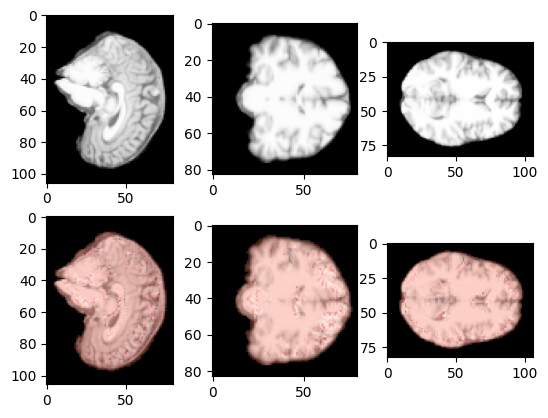

In [104]:
fig, ax = plt.subplots(2, 3)
brain = next(iter(test_dl))["t1n"][0,0].detach().cpu().numpy()
attr = norm(attributions[0].detach().cpu().numpy())
attr[brain <= 0] = 0
plt_points = [x//2 for x in brain.shape]
ax[0,0].imshow(brain[plt_points[0]], cmap="Greys_r")
ax[0,1].imshow(brain[:,plt_points[1]], cmap="Greys_r")
ax[0,2].imshow(brain[:,:,plt_points[2]], cmap="Greys_r")
ax[1,0].imshow(brain[plt_points[0]], cmap="Greys_r")
ax[1,0].imshow(attr[plt_points[0]], alpha=attr[plt_points[0]]*0.7, cmap="Reds")
ax[1,1].imshow(brain[:,plt_points[1]], cmap="Greys_r")
ax[1,1].imshow(attr[:,plt_points[1]], alpha=attr[:,plt_points[1]]*0.7, cmap="Reds")
ax[1,2].imshow(brain[:,:,plt_points[2]], cmap="Greys_r")
ax[1,2].imshow(attr[:,:,plt_points[2]], alpha=attr[:,:,plt_points[2]]*0.7, cmap="Reds")
plt.show()